# DECOMON tutorial #2
## Local Robustness to sensor noise for Regression

### Introduction

Embedding simulation models developed during the design
of a platform opens a lot of potential new functionalities
but requires additional certification. Usually, these models require too much computing power, take too much time to run
so we need to build an approximation of these models that can
be compatible with operational constraints, hardware constraints, and real-time constraints. Also, we need to prove that
the decisions made by the system using the surrogate model
instead of the reference one will be safe.

A first assessment that can be performed is the **robustness of the prediction given sensor noise**: demonstrating that despite sensor noise, the neural network prediction remains consistent.

Local Robustness to **sensoir noise** can be performed efficiently thanks to formal robustness. In this notebook, we demonstrate how to derive deterministic upper and lower bounds of the output prediction of a neural network in the vicinity of a test sample.

### Toy Example: Electric Motor Temperature

We will demonstrate how to perform **Local Robustness to sensoir noise** on a surrogate toy case.
A neural network is trained to infer the temperature of a permanent-magnet synchronous motor ([PMSM](https://en.wikipedia.org/wiki/Synchronous_motor#Permanent-magnet_motors) ) given correlated features:

+ ambiant: Ambient temperature as measured by a thermal sensor located closely to the stator.
+ coolant: Coolant temperature. The motor is water cooled. Measurement is taken at outflow.
+ u_d: Voltage d-component
+ u_q: Voltage q-component
+ motor_speed
+ torque: Torque induced by current.
+ i_d: Current d-component
+ i_q: Current q-component


The recorded temperature refers to the Permanent Magnet surface temperature (pm) representing the rotor temperature. This was measured with an infrared with 140 hrs recordings. Distinctive sessions are identified with "profile_id". You will find additional information in the [official data repository](https://www.kaggle.com/wkirgsn/electric-motor-temperature)

### Preprocessing: downloading the data and the neural network

In [1]:
import os
import pandas as pd
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import matplotlib.pyplot as plt
from numpy.testing import assert_almost_equal

you can download directly the data on the [official data repository](https://www.kaggle.com/wkirgsn/electric-motor-temperature). For the sake of context, we display statistical informations of this dataset.

In [2]:
data = pd.read_csv("./data/pmsm_temperature_data_.csv")
data.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


Now it's time to dinstinguish our target (output, *pm*) and our features (inputs). We build the train and test set with a 80/20 ratio
given the *profile_id*. Indeed we don't want to be biased by the recording session.

In [3]:
y = data["pm"]                    #column "pm" is our target
X = data.drop(["pm"], axis = 1) #the other columns are our features

# sort given profile_id and split into train and test (80% of the sessions will be used for training the NN)
index = []
for i in range(X['profile_id'].min(), X['profile_id'].max()):
    if i in X['profile_id']:
        index.append(i)
        
n_train = int(0.8*len(index))
is_train = X['profile_id'] <= index[n_train]
is_test = X['profile_id'] > index[n_train]

# conversion to numpy array
X_train = X[is_train].drop(["profile_id"], axis = 1).to_numpy()
X_test = X[is_test].drop(["profile_id"], axis = 1).to_numpy()
y_train = y[is_train].to_numpy()
y_test = y[is_test].to_numpy()

We train a toy model. We did not seek to obtain the most accurate model as this notebook is only intended for a proof of concept

In [4]:
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[-1]))
model.add(Activation('relu'))
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dense(1))

2022-10-27 16:02:29.323104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.compile('adam', 'mse')
model.fit(X_train, y_train, batch_size=32, shuffle=True, validation_split=0.2, 
          epochs=3)

Epoch 1/3
17106/17106 [==============================] - 16s 913us/step - loss: 0.1635 - val_loss: 0.2309
Epoch 2/3
17106/17106 [==============================] - 15s 897us/step - loss: 0.1178 - val_loss: 0.2138
Epoch 3/3
17106/17106 [==============================] - 15s 881us/step - loss: 0.1071 - val_loss: 0.1833


## Local Robustness to sensoir noise

In this section, we detail how to derive upper 
and lower bounds on the output of a neural network given some noise on the input. 
Hence we are able to bound formally the worst case prediction given noise.
In that order, we will use the [decomon](https://gheprivate.intra.corp/CRT-DataScience/decomon/tree/master/decomon) library. Decomon combines several optimization trick, including linear relaxation
to get state-of-the-art outer approximation.

To use **decomon** for **local robustness to sensor noise** we first need the following imports:
+ *from decomon.models import convert*: to convert our current Keras model into another neural network nn_model. nn_model will output the same prediction that our model and adds extra information that will be used to derive our formal bounds. For a sake of clarity, how to get such bounds is hidden to the user, but an interested reader may refer to XXX

+ *from decomon import get_upper_noise*: a generic method to get an upper bound on the prediction of a neural network in a $L_p$ (p $\in \{1, 2, \infty\} $) ball with radius epsilon around a sample. If the type of Lp norm is not provided, we assume that we consider a worst case noise independently on every input variable ($L_{\infty}$).

In [6]:
import sys
sys.path.append('..')
import decomon
from decomon.models import convert, clone
from decomon import get_upper_noise, get_lower_noise, get_range_noise, get_upper_box
from decomon import get_upper_box, get_lower_box

## Noise $L_{\infty}$

we will first consider a worst case noise independently on every input variable ($L_{\infty}$).
We pick a random subset of the test dataset and compute an envelop of the network prediction with a noise epsilon

In [18]:
# you can play with the magnitude of the noise
epsilon = 1e-2

# size of the subset of the test set
n_rand = 1000
# sampling from the test set
index_rand = np.random.permutation(len(X_test))[:n_rand]
X_rand = X_test[index_rand]
y_pred = model.predict(X_rand)[:,0]

32/32 [==============================] - 0s 820us/step


the **get_upper_noise** and **get_lower_noise methods** return upper and lower bounds over a batchs of samples

In [19]:
# compute formal bounds
start_time = time.process_time()  #optional
upper_test = get_upper_noise(model, X_rand, epsilon)[:, 0]
lower_test = get_lower_noise(model, X_rand, epsilon)[:, 0]
end_time = time.process_time()  #optional

print('Average time to get an upper and a lower bound:{} s'.format((end_time-start_time)/n_rand))

32/32 [==============================] - 1s 2ms/step
Average time to get an upper and a lower bound:0.00482226 s


You can compute both bounds within a single call to the method **get_range_noise**

In [20]:
upper_test_bis, lower_test_bis = get_range_noise(model, X_rand, epsilon)

32/32 [==============================] - 1s 2ms/step


We can assess that the output results remain unchanged

In [21]:
assert_almost_equal(upper_test, upper_test_bis[:,0], decimal=4, err_msg="error")
assert_almost_equal(lower_test, lower_test_bis[:,0], decimal=4, err_msg="error")

If you plan to compute both upper and lower bounds or call those methods several time in your script, the most efficient way is to call the method on the decomon version itself. To do so, you first need to convert your model:

In [35]:
start_time = time.process_time() #optional
convex_domain = {'name': 'ball', 'p': np.inf, 'eps': epsilon}
nn_model = clone(model, method='crown-hybrid', convex_domain=convex_domain)
upper_test_ = get_upper_noise(nn_model, X_rand, epsilon)[:, 0]
lower_test_ = get_lower_noise(nn_model, X_rand, epsilon)[:, 0]
end_time = time.process_time()  #optional
print('Average time to get an upper and a lower bound:{} s'.format((end_time-start_time)/n_rand))

32/32 [==============================] - 0s 2ms/step
Average time to get an upper and a lower bound:0.0024532299999999907 s


We can assess that the output results remain unchanged

In [37]:
assert_almost_equal(upper_test, upper_test_, decimal=4, err_msg="error")
assert_almost_equal(lower_test, lower_test_, decimal=4, err_msg="error")

In [ ]:
assert_almost_equal(upper_test, ub_p, decimal=4, err_msg="error")

In [ ]:
upper_test[np.argsort(y_pred)].min

In [ ]:
upper_test = u
lower_test = l

### Visualization

Text(0.5, 1.0, 'Formal robustness in a box')

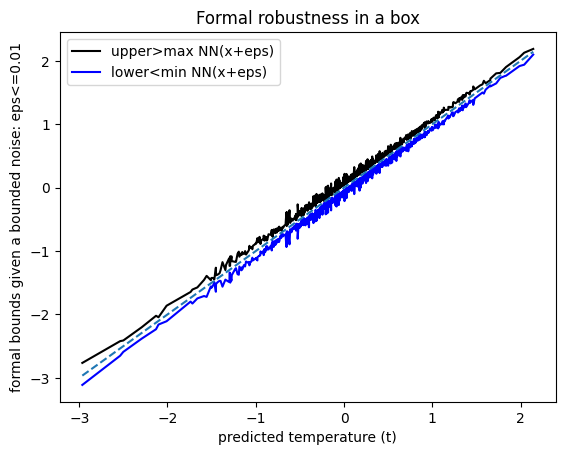

In [23]:
plt.plot(np.sort(y_pred), upper_test_[np.argsort(y_pred)], c='k')
plt.plot(np.sort(y_pred), lower_test_[np.argsort(y_pred)], c='b')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], '--')
plt.legend(['upper>max NN(x+eps)', 'lower<min NN(x+eps)'])
plt.xlabel('predicted temperature (t)')
plt.ylabel('formal bounds given a bounded noise: eps<={}'.format(epsilon))
plt.title('Formal robustness in a box')

## Noise $L_{2}$

Usually, sensor noise is approximated by Gaussian noise. One way to represent it with formal methods is to use an euclidian ball. We provide an illustration of how to express Gaussian noise in a 2D domain as a pink ball that covers the distribution with high probability.

<img src="./data/ball_fm.png" alt="Decomon!" width="400"/>

In [24]:
# compute formal bounds
start_time = time.process_time()  #optional
upper_test, lower_test = get_range_noise(model, X_rand, epsilon, p=2)
upper_test = upper_test[:, 0]
lower_test = lower_test[:, 0]
end_time = time.process_time()  #optional

print('Average time to get an upper and a lower bound:{} s'.format((end_time-start_time)/n_rand))

32/32 [==============================] - 1s 2ms/step
Average time to get an upper and a lower bound:0.0024149749999999985 s


Text(0.5, 1.0, 'Formal robustness in an euclidean ball')

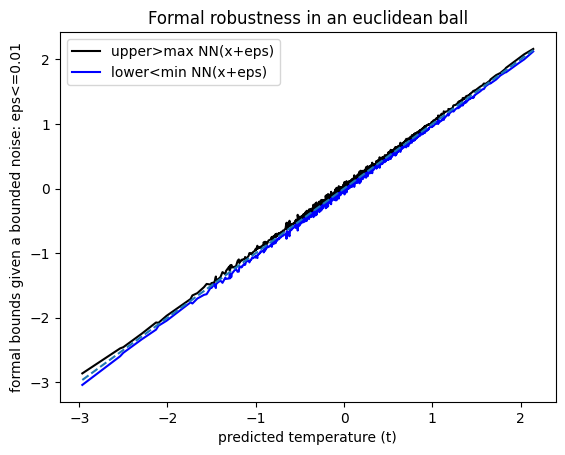

In [25]:
plt.plot(np.sort(y_pred), upper_test[np.argsort(y_pred)], c='k')
plt.plot(np.sort(y_pred), lower_test[np.argsort(y_pred)], c='b')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], '--')
plt.legend(['upper>max NN(x+eps)', 'lower<min NN(x+eps)'])
plt.xlabel('predicted temperature (t)')
plt.ylabel('formal bounds given a bounded noise: eps<={}'.format(epsilon))
plt.title('Formal robustness in an euclidean ball')